### Showing the trends and mapping them:

In [487]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Normalizer, StandardScaler


from folium import plugins

import matplotlib.pyplot as plt

#sql stuff:
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [550]:
#FUNCTIONS:

def get_nbds(new_descp):
    """
    builds a score for each neighborhood given a description as follows:
    ass up the distances
    """
    neighbors = knn.kneighbors(model.transform([new_descp]))
    closest_listings = neighbors[1][0]
    results = train.iloc[closest_listings][["neighbourhood_cleansed"]]
    results["distance"] = neighbors[0][0]

    #invert the distance:
    results["distance"] = results["distance"].max() + 1 - results["distance"]
    nbd_score = results.groupby("neighbourhood_cleansed")["distance"].sum().sort_values(ascending = False)


    nbd_score = pd.concat((nbd_score, nbd_counts), 1)
    nbd_score["weighted_score"] = nbd_score["distance"]/np.log(nbd_score["neighbourhood_cleansed"])

    return nbd_score

def locations_of_best_match(new_descp):
    neighbors = knn.kneighbors(model.transform([new_descp]))
    closest_listings = neighbors[1][0]
    results = train.iloc[closest_listings]
    return results


def draw_point_map(results, nr_pts = 300):
    map_osm = folium.Map(tiles='Cartodb Positron', location = [40.661408, -73.961750])
    #this is stupidly slow:
    for index, row in results[:nr_pts].iterrows():
        folium.CircleMarker(location=[row["latitude"], row["longitude"]], radius=row["latitude"], color = "pink").add_to(map_osm)

    return(map_osm)



def get_heat_map(descp):
    map_osm = folium.Map(tiles='Cartodb Positron', location = [40.7831, -73.970], zoom_start=13)
    results = locations_of_best_match(descp)
    temp = results[["latitude", "longitude"]].values.tolist()
    

    map_osm.add_children(plugins.HeatMap(temp, min_opacity = 0.4, radius = 20, blur = 30,
                                         gradient = return_color_scale(scale_1),
                                         name = descp))
    
    
    folium.LayerControl().add_to(mapa)
    return map_osm

In [626]:
dbname = 'airbnb_db'
username = 'alexpapiu'
con = psycopg2.connect(database = dbname, user = username)
train = pd.read_sql_query("SELECT * FROM location_descriptions", con)

nbd_counts = train["neighbourhood_cleansed"].value_counts()

descp = train[["id", "neighborhood_overview"]]

descp = descp.drop_duplicates()

In [627]:
train

,id,neighborhood_overview,neighbourhood_cleansed,city,latitude,longitude
0,685006.0,The apartment is right across the street from ...,Prospect-Lefferts Gardens,Brooklyn,40.661408,-73.961750
1,9461238.0,"Prime Williamsburg, the hot South side: Steps ...",Williamsburg,Brooklyn,40.716320,-73.957255
2,4873690.0,"Long Island City is the ultimate, in my mind, ...",Long Island City,Queens,40.742824,-73.949939
3,14179829.0,"Located on a beautiful, quiet tree lined stree...",Sunnyside,Queens,40.741264,-73.925798
4,7364064.0,This spacious three bedroom is located in the ...,Stuyvesant Town,New York,40.733109,-73.979277
5,4349358.0,"The apartment is located in a beautiful, safe,...",Upper West Side,New York,40.774744,-73.978863
6,11165126.0,"Architecture, art, and fine dining meets a thr...",Chelsea,New York,40.738694,-73.992643
7,16014791.0,I love the convenient of walking distance to e...,Hell's Kitchen,New York,40.755364,-73.999498
8,1727923.0,Williamsburg is the most dynamic neighborhood ...,Williamsburg,Brooklyn,40.713157,-73.956484
9,3562906.0,This is centrally located in midtown. Times Sq...,Hell's Kitchen,New York,40.766326,-73.990984


In [632]:
#MODEL:
#spell check:
model = make_pipeline(TfidfVectorizer(stop_words = "english", min_df = 5, ngram_range = (1,1)),
                      TruncatedSVD(100),
                      Normalizer())

knn = NearestNeighbors(500, metric = "cosine", algorithm = "brute")

X = descp["neighborhood_overview"]
X_proj = model.fit_transform(X)
knn.fit(X_proj)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=500, p=2, radius=1.0)

In [596]:
model

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_i...00, n_iter=5,
       random_state=None, tol=0.0)), ('normalizer', Normalizer(copy=True, norm='l2'))])

In [602]:
from sklearn.externals import joblib
joblib.dump(model, 'tf_idf_model.pkl') 

AttributeError: 'NearestNeighbors' object has no attribute 'dump'

In [600]:
model = joblib.load('tf_idf_model.pkl') 

In [636]:
descp = " trendy hip cool"

In [637]:
nbd_score = get_nbds(descp)

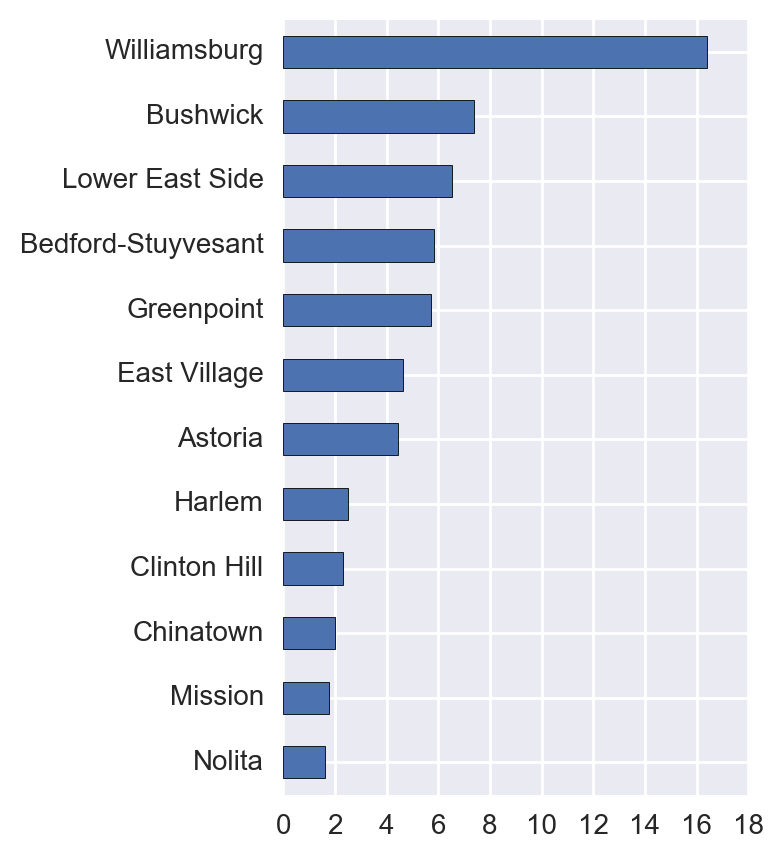

In [643]:
from pylab import rcParams
rcParams['figure.figsize'] = 3, 5
nbd_score["weighted_score"].dropna().sort_values().tail(12).plot(kind = "barh")


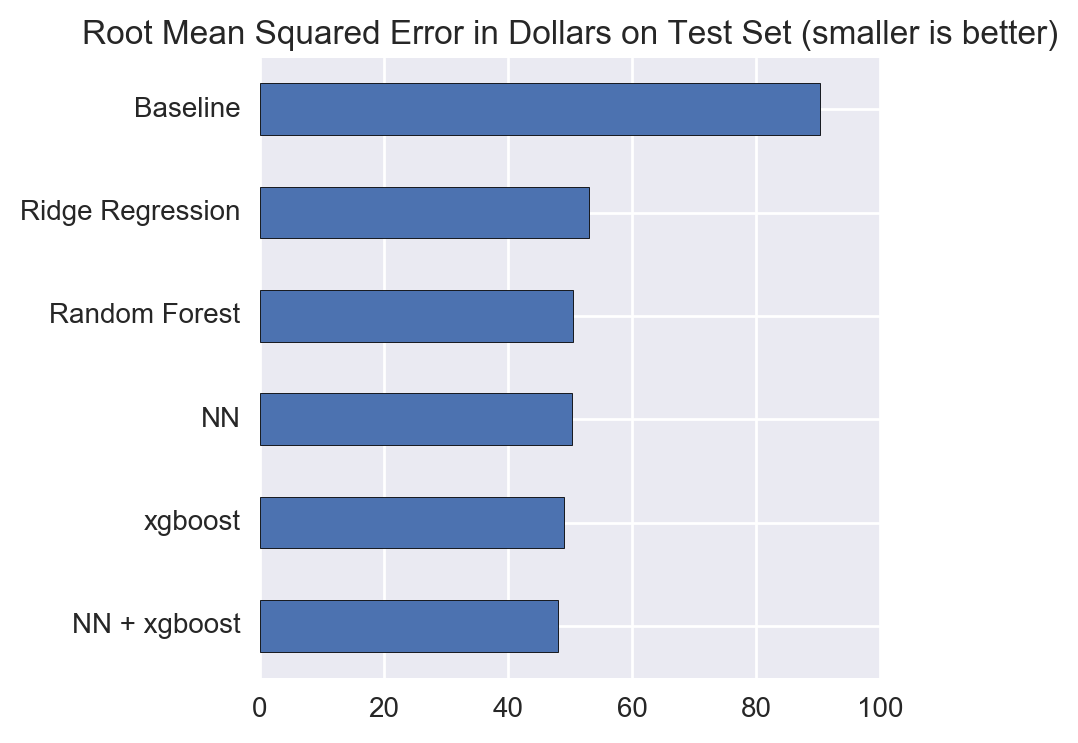

In [651]:
rcParams['figure.figsize'] = 4, 4
(pd.Series([90.4, 53, 50.5, 50.3, 49.1, 48],
           index = ["Baseline", "Ridge Regression", "Random Forest", "NN", "xgboost", "NN + xgboost"]).sort_values()
.plot(kind = "barh", title = "Root Mean Squared Error in Dollars on Test Set (smaller is better)"))

In [215]:
results = locations_of_best_match(descp)

In [569]:
get_heat_map("hip urban gritty")

In [521]:
def add_heat_layer(mapa, descp, scale  = scale_2):

    results = locations_of_best_match(descp)
    temp = results[["latitude", "longitude"]].values.tolist()

    mapa.add_children(plugins.HeatMap(temp, min_opacity = 0.4, radius = 30, blur = 30,
                                      gradient = return_color_scale(scale),
                                      name = descp))
    return mapa

In [522]:
scale_2 = ["#f2eff1", "#f2eff1", "#3E4A89", "#31688E", "#26828E", "#1F9E89", "#35B779",
               "#6DCD59", "#B4DE2C", "#FDE725"]

scale_1 = ["#f2eff1", "#f2eff1", "#451077", "#721F81", "#9F2F7F", "#CD4071",
           "#F1605D",  "#FD9567",  "#FEC98D", "#FCFDBF"]

scale_3 = ["#f2eff1", "#f2eff1", "#4B0C6B", "#781C6D", "#A52C60", "#CF4446",
           "#ED6925", "#FB9A06", "#F7D03C", "#FCFFA4"]

def return_color_scale(scale):
    df = pd.Series(scale)
    df.index = np.power(df.index/10, 1/2)
    return df.to_dict()


In [634]:
mapa = get_heat_map("hip cute thrift stores bars")
add_heat_layer(mapa, "gritty authentic")
add_heat_layer(mapa, "chinese", scale = scale_3)

folium.LayerControl().add_to(mapa)

In [615]:
#normalize the heat map
#take distance into account.
#datashader 
mapa = get_heat_map("russian")

In [635]:
mapa

In [588]:
mapa.save("map_test")

In [589]:
ls

Thumbnails/
clean_listings.csv
dedup_listings.csv
map_test
mock_clean_data.csv
neighbourhoods.geojson
new-york-city_2015-01-01_data_listings.csv
new-york-city_2015-12-02_data_listings.csv
new-york-city_2016-12-03_data_listings.csv
new-york-city_2016-12-03_data_listings.csv.gz
san-francisco_2016-07-02_data_listings.csv
san-francisco_2016-07-02_data_listings.csv.gz
sm_listings.csv


In [515]:
def get_heat_map(descp):
    map_osm = folium.Map(tiles='Cartodb Positron', location = [40.7831, -73.970], zoom_start=13)
    results = locations_of_best_match(descp)
    temp = results[["latitude", "longitude"]].values.tolist()
    

    map_osm.add_children(plugins.HeatMap(temp, min_opacity = 0.4, radius = 30, blur = 30,
                                         gradient = return_color_scale(scale_1),
                                         name = descp))
    
    
    folium.LayerControl().add_to(mapa)
    return map_osm

In [604]:
get_heat_map("cocktail")

In [560]:
danger = train[train.neighborhood_overview.str.contains("dangerous")]

In [562]:
danger.neighborhood_overview.iloc[1]

'Bed Stuy has a diverse mix of students, families, hipsters, artists and creative professionals.  Bed Stuy has a strong community and abundent attractive brownstone houses and tree lined streets.  Conveniently located 1 block from the subway you can be in Manhattan in 20 - 30 mins door to door. This is a very racially diverse part of Brooklyn - If you are at all narrow minded and or equate minorities with being dangerous than this is not the house for you.  We under no circumstance tolerate that kind of behavior.  Our doors are open to all nationalities and sexual orientation.  Everyone is welcome here regardless of race - creed - color - age or sexual orientation.'

In [631]:
get_heat_map("close to central park")

In [633]:
get_heat_map("close to central park")

In [586]:
import folium
map_osm = folium.Map(location=[45.5236, -122.6750])

In [590]:
m.create_map(path='map.html')

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: Map.create_map is deprecated. Use Map.save instead
  if __name__ == '__main__':


In [593]:
map_osm = folium.Map(location=[45.5236, -122.6750])